# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [8]:
#conda install -c conda-forge pyLDAvis

In [9]:
#conda install -c conda-forge spacy

In [44]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

#import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from wordcloud import  STOPWORDS


from collections import Counter, defaultdict

#nlp = spacy.load('en_core_web_sm')



In [45]:
# add any additional libaries you need here
import nltk
nltk.download('brown')


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\ahzha\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [46]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [47]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [48]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [49]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='category'>

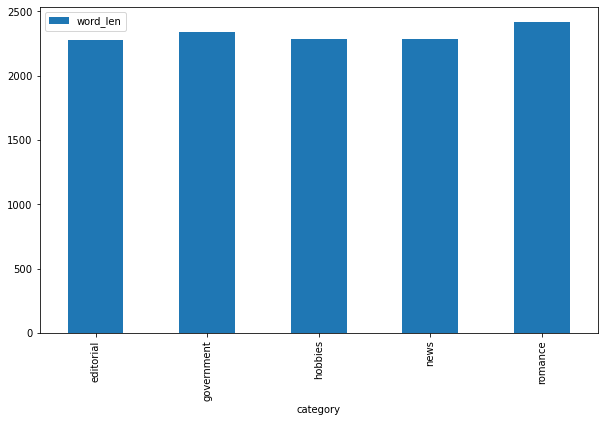

In [50]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [56]:
count_text_vectorizer = CountVectorizer(stop_words=STOPWORDS, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\ahzha\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  % sorted(inconsistent)


(166, 5079)

In [22]:
count_text_vectors

<166x5079 sparse matrix of type '<class 'numpy.int64'>'
	with 78998 stored elements in Compressed Sparse Row format>

In [23]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=STOPWORDS, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 5079)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: 
Bag of words based text vector in the form of a sparse matrix; Tfidf based text vector in the form of a sparse matrix

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [24]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

C:\Users\ahzha\miniconda3\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [25]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.47)
  president (0.42)
  kennedy (0.41)
  united (0.40)
  khrushchev (0.38)

Topic 01
  said (0.77)
  didn (0.41)
  ll (0.40)
  thought (0.37)
  back (0.34)

Topic 02
  mrs (2.33)
  mr (0.74)
  said (0.72)
  miss (0.46)
  car (0.46)

Topic 03
  state (0.38)
  development (0.35)
  tax (0.32)
  sales (0.29)
  may (0.28)

Topic 04
  game (0.95)
  league (0.69)
  ball (0.67)
  baseball (0.65)
  team (0.62)


C:\Users\ahzha\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [30]:
# Your code here
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", stopwords = STOPWORDS,max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(7,7))
#         print(f'TOPIC - {topic}')
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f'TOPIC - {topic}')

def plot_cat_brown():
    for cat in df['category'].unique():
        x = df[df['category']==cat]['text'].values
        s = ''
        for i in x:
            s = s + i
        s = s.split()
        from collections import Counter
        d = Counter(s)
        dd = d.copy()
        for i in d:
            if i in STOPWORDS or len(i)==1 or not i.isalpha():
                del dd[i]
        t = ' '.join(list(dict(sorted(dd.items(),key=lambda y:y[1],reverse=True)[:100])))

        wordcloud = WordCloud(width = 960, height = 540,
                        background_color ='white',stopwords = STOPWORDS,
                        max_words=100).generate(t)

        # plot the WordCloud image  
        plt.title(f'TOPIC - {cat}')
#         plt.figure(figsize = (7,7), facecolor = None)
        plt.imshow(wordcloud)
        plt.show()

C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=t

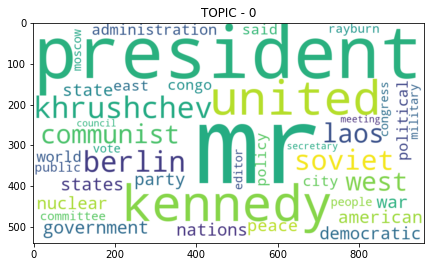

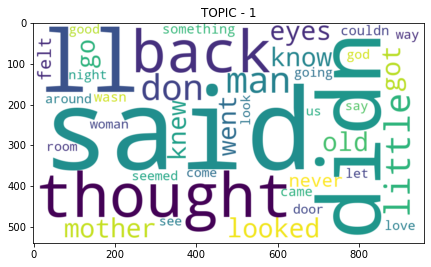

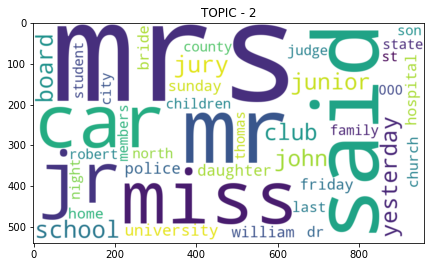

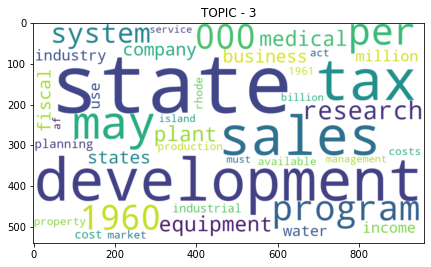

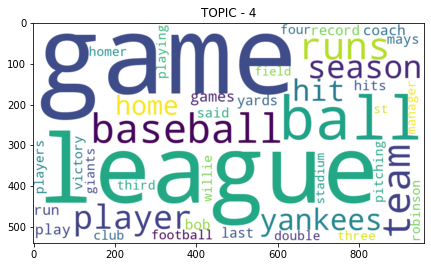

In [31]:
wordcloud_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())

C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=t

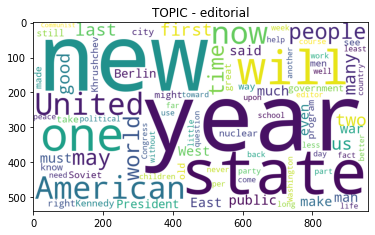

C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=t

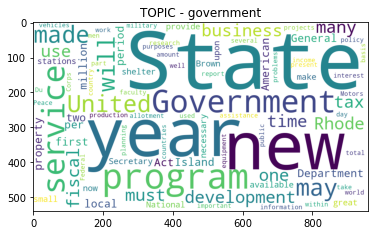

C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=t

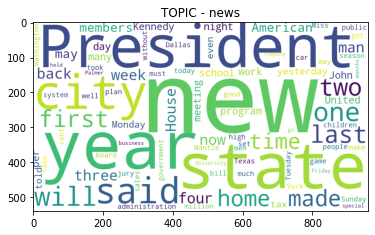

C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=t

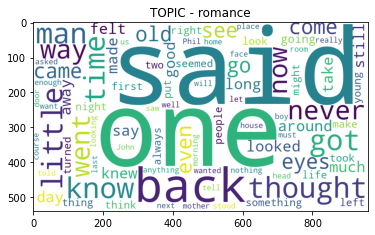

C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordclo

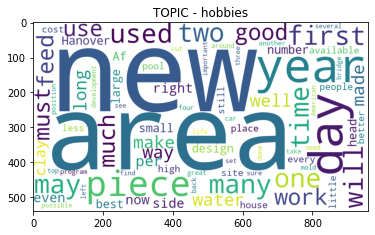

In [32]:
plot_cat_brown()

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: topic-4 is related to sports/hobbies, topic-2 is related to the government,topic-1 is related to love. for other topics, its harder to categorize.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [33]:
# Your code here
from sklearn.decomposition import TruncatedSVD

svd_text_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

C:\Users\ahzha\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  bo

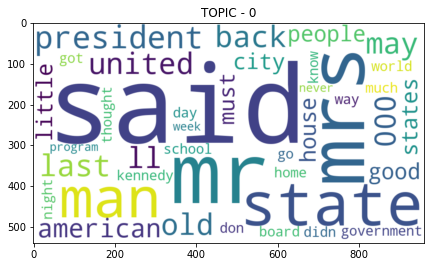

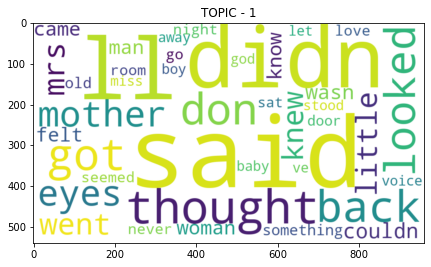

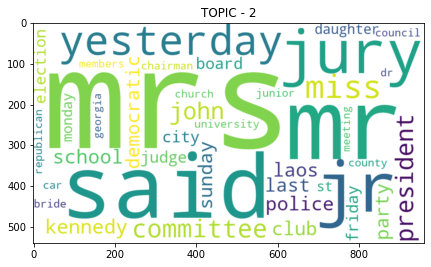

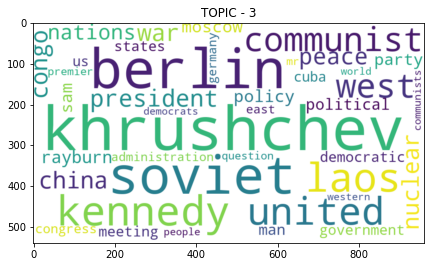

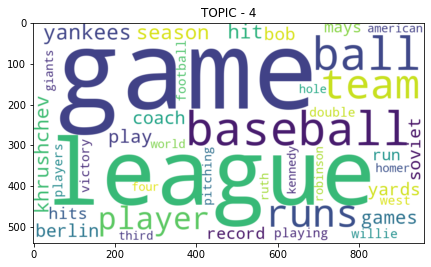

In [34]:
wordcloud_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: topic-4 is related to sports/hobbies, topic-2 is related to the news, topic -3 is related to politics, topic-0 is related to politics/governemment, 

In [35]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.41)
  mr (0.23)
  mrs (0.20)
  state (0.19)
  man (0.16)

Topic 01
  said (3.01)
  ll (2.21)
  didn (2.14)
  thought (1.79)
  got (1.62)

Topic 02
  mrs (4.51)
  mr (1.95)
  said (1.49)
  jr (0.87)
  jury (0.83)

Topic 03
  khrushchev (3.28)
  berlin (2.62)
  soviet (2.45)
  kennedy (2.35)
  laos (2.24)

Topic 04
  game (3.90)
  league (2.78)
  baseball (2.75)
  ball (2.60)
  team (2.53)


C:\Users\ahzha\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Q: What is your interpretation of the display topics output? 

A:  LSA is better

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [36]:
# Fit your LDA model here
from sklearn.decomposition import LatentDirichletAllocation

lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [37]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names())


Topic 00
  state (0.84)
  states (0.66)
  government (0.55)
  united (0.54)
  may (0.47)

Topic 01
  said (1.20)
  mrs (0.71)
  last (0.58)
  mr (0.47)
  home (0.45)

Topic 02
  world (0.58)
  american (0.57)
  may (0.51)
  college (0.45)
  people (0.39)

Topic 03
  said (1.32)
  back (0.65)
  man (0.53)
  little (0.53)
  know (0.48)

Topic 04
  may (0.70)
  used (0.60)
  use (0.53)
  water (0.47)
  af (0.47)


C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\ahzha\miniconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=t

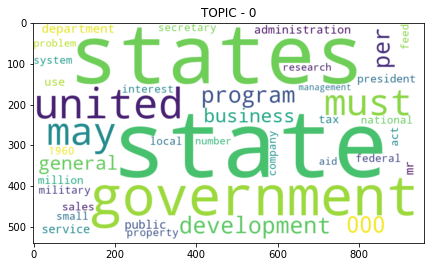

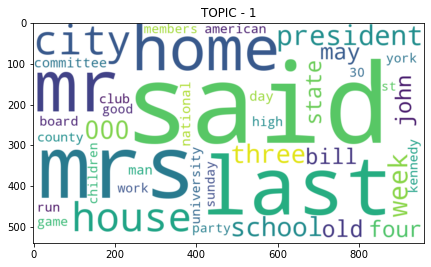

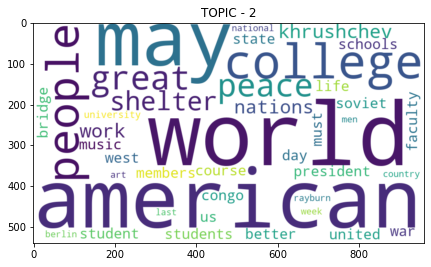

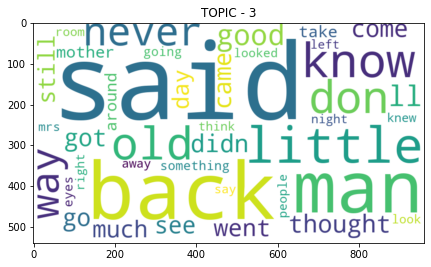

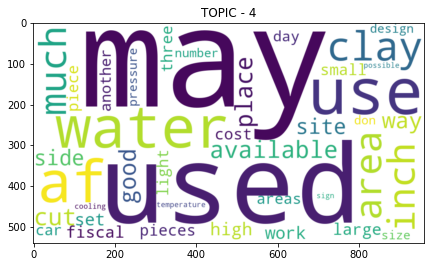

In [38]:
wordcloud_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names())

Q: What inference do you draw from the displayed topics for your LDA model? 

A:  For LDA, the topics are better than above models.


In [39]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

C:\Users\ahzha\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: It is a visualization of words distribution for each topic. Each salient term has its own frequency. Topics are represented by the scatter plot.